# Coronavirus Bar Chart Race April 26, 2020 by Dr. Farhad Zulfiqar

References: <br>
Original Bar Chart Race Tutorial: https://medium.com/@chrispfchung/the-coronavirus-bar-chart-race-the-race-you-dont-want-to-win-1ce2aef80310<br>
Updated COVID-19 Dataset: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML # display media control overlay of bar chart race
from tqdm import tqdm # show progress bar during loops
%matplotlib inline

#You may also need to install this: 
#pip install pycountry-convert
#or
#Go to command prompt and then do above pycountry-convert command
#or
#conda install pycountry-convert 

In [2]:
# load in dataset
# this is a good dataset that broke down the time stamps into M/D/Y
# It also has 11341 data points for all countries affected by COVID-19
# there are not as many states as countries so there are null values
df = pd.read_csv('covid_19_data.csv')
print(df.info()) 
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18646 entries, 0 to 18645
Data columns (total 8 columns):
SNo                18646 non-null int64
ObservationDate    18646 non-null object
Province/State     9188 non-null object
Country/Region     18646 non-null object
Last Update        18646 non-null object
Confirmed          18646 non-null float64
Deaths             18646 non-null float64
Recovered          18646 non-null float64
dtypes: float64(3), int64(1), object(4)
memory usage: 1.1+ MB
None


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0


## Clean Data First

#### I like to lower case and add underscores to my column names for easier access


In [3]:
df.columns = [x.lower() for x in df.columns]
df.columns = [x.replace(' ', '_') for x in df.columns]
df.columns

Index(['sno', 'observationdate', 'province/state', 'country/region',
       'last_update', 'confirmed', 'deaths', 'recovered'],
      dtype='object')

#### turn float to integer values as there cannot be a "4.5" confirmed sick person. This data must be discrete.

In [4]:
df['confirmed'] = df['confirmed'].apply(lambda x: int(x))

# do the same for deaths and recovered
df['deaths'] = df['deaths'].apply(lambda x: int(x))
df['recovered'] = df['recovered'].apply(lambda x: int(x))

# show what results looks like
df['confirmed'].head(3)

0     1
1    14
2     6
Name: confirmed, dtype: int64

#### change 'observationdate' column into datetime datatype

In [5]:
from datetime import date
from datetime import datetime

# this code turns string '03/23/2020' to 2020-0323, which is in datetime format
print(datetime.strptime(df['observationdate'][10000], "%m/%d/%Y").date())

# make every string date into datetime format using .apply method
df['observationdate'] = df['observationdate'].apply(
    lambda x: datetime.strptime(x, "%m/%d/%Y").date())
print(f"Result: {df['observationdate'][0]}, {type(df['observationdate'][0])}")

2020-03-29
Result: 2020-01-22, <class 'datetime.date'>


#### remove any country's leading whitespace

In [6]:
df['country/region'] = df['country/region'].apply(lambda x: x.lstrip())

#### Change the Name of Some Countries: <br>
Later on in my code I assign a color to each country according to their continent. I input country names into a python library called pycountry that outputs its continent. However, some of the countries are not recognized by the way our data has put it. An example is below. It should read "Democratic Republic of the Congo" rather than "Congo (Kinshasa)" <br>
I change them all now. <br>
<br>
I used this wikipedia page to help me find corresponding country/country codes
<br>
Source: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2

For example, the error says: <b>KeyError:</b> "Invalid Country Name: 'Congo (Kinshasa)'"

In [7]:
df.loc[(df['country/region'] == 'Mainland China'), 'country/region'] = 'China'

df.loc[(df['country/region'] == 'Congo (Kinshasa)'), 'country/region'] = 'Democratic Republic of the Congo'
df.loc[(df['country/region'] == 'Congo (Brazzaville)'), 'country/region'] = 'Republic of the Congo'

df.loc[(df['country/region'] == 'Burma'), 'country/region'] = 'Myanmar'

df.loc[(df['country/region'] == 'occupied Palestinian territory'), 'country/region'] = 'Palestine'
df.loc[(df['country/region'] == 'West Bank and Gaza'), 'country/region'] = 'Palestine'

df.loc[(df['country/region'] == 'Republic of Ireland'), 'country/region'] = 'Ireland'

df.loc[(df['country/region'] == 'Saint Barthelemy'), 'country/region'] = 'Saint Barthélemy'

df.loc[(df['country/region'] == 'Bahamas, The'), 'country/region'] = 'Bahamas'
df.loc[(df['country/region'] == 'The Bahamas'), 'country/region'] = 'Bahamas'

df.loc[(df['country/region'] == 'Gambia, The'), 'country/region'] = 'Gambia'
df.loc[(df['country/region'] == 'The Gambia'), 'country/region'] = 'Gambia'

df.loc[(df['country/region'] == "('St. Martin',)"), 'country/region'] = 'Saint Martin'

df.loc[(df['country/region'] == "Curacao"), 'country/region'] = 'Curaçao'

df.loc[(df['country/region'] == "North Ireland"), 'country/region'] = 'United Kingdom'

df.loc[(df['country/region'] == 'Reunion'), 'country/region'] = 'Réunion'

df.loc[(df['country/region'] == 'UK'), 'country/region'] = 'United Kingdom'

df.loc[(df['country/region'] == 'US'), 'country/region'] = 'United States of America'


# Trying to figure out how pycountry will accept the "Holy See" Let me know if you know!
# df.loc[(df['country/region'] == 'Holy See'), 'country/region'] = 'Vatican City State (Holy See)'
# df.loc[(df['country/region'] == 'Holy See'), 'country/region'] = 'Vatican City State'
# df.loc[(df['country/region'] == 'Vatican City'), 'country/region'] = 'The Vatican'
# df.loc[(df['country/region'] == 'Holy See'), 'country/region'] = 'Holy See (Vatican City State)'
# df.loc[(df['country/region'] == 'Holy See'), 'country/region'] = 'State of the Vatican City'
# df.loc[(df['country/region'] == 'Holy See'), 'country/region'] = 'See of Rome'
# df.loc[(df['country/region'] == 'Holy See'), 'country/region'] = 'Vatican'

# Same for Kosovo
# df.loc[(df['country/region'] == 'Kosovo'), 'country/region'] = 'Republic of Kosovo'


# an example of how the changes look
df[df['country/region'] == 'United States of America'].iloc[0:3]

,sno,observationdate,province/state,country/region,last_update,confirmed,deaths,recovered
31,32,2020-01-22,Washington,United States of America,1/22/2020 17:00,1,0,0
69,70,2020-01-23,Washington,United States of America,1/23/20 17:00,1,0,0
117,118,2020-01-24,Washington,United States of America,1/24/20 17:00,1,0,0


#### Visualize and then Remove 'Others' Column (Diamond Princess cruise ship data)
##### The country/region called 'Others' is the diamond princess cruise ship that was affected by the coronavirus. I'm not including it in the bar chart race since it is not a country. However,  I dig into this data before I remove it.

In [8]:
#upon looking at this data, the cruise ship confirms cases on 2-7-2020
# because the confirmed numbers taper off at 2-26, I will plot up to that date.
df[(df['country/region'] == 'Others')].head()

#snippet of our cruise ship data
df[(df['country/region'] == 'Others') & (df['observationdate'] < date(2020,2,27))].tail()

,sno,observationdate,province/state,country/region,last_update,confirmed,deaths,recovered
2034,2035,2020-02-22,Diamond Princess cruise ship,Others,2020-02-20T15:53:03,634,2,1
2118,2119,2020-02-23,Diamond Princess cruise ship,Others,2020-02-23T22:33:03,691,3,0
2204,2205,2020-02-24,Diamond Princess cruise ship,Others,2020-02-23T22:33:03,691,3,0
2294,2295,2020-02-25,Diamond Princess cruise ship,Others,2020-02-23T22:33:03,691,3,0
2388,2389,2020-02-26,Diamond Princess cruise ship,Others,2020-02-26T19:33:02,705,4,10


In [9]:
# convert datetime for interpretable string format in plot

dates = df[(df['country/region'] == 'Others') & (df['observationdate'] < date(2020,2,27))]['observationdate']
dates = list(dates.apply(lambda x: x.strftime("%b %d")))

### Plot Line Graph of Diamond Princess infection rate

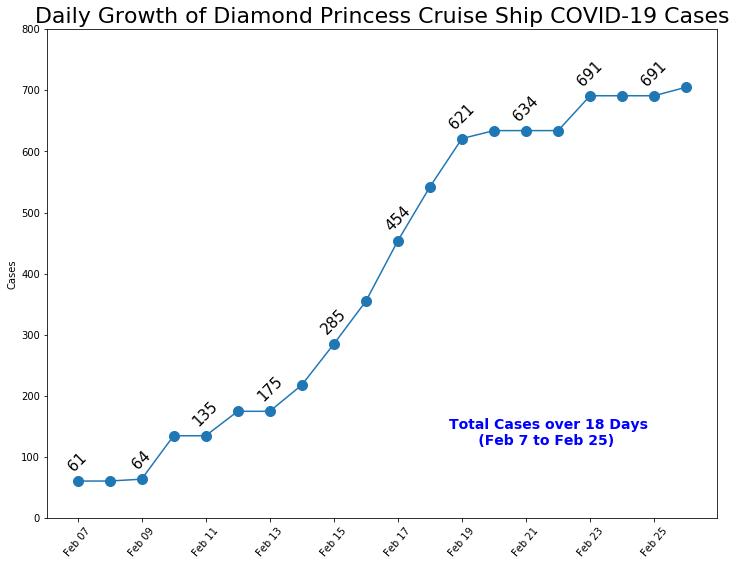

In [10]:
x = dates
y = df[(df['country/region'] == 'Others') & (df['observationdate'] < date(2020,2,27))]['confirmed']

plt.figure(figsize=(12,9))

# plt.plot(x, y)
plt.plot(x, y, marker='o', markersize= 10)

# plt.plot(x, y, marker='X', markersize= 10, color='green',mfc='red')
plt.ylabel('Cases')
plt.xlabel(' ')
plt.xticks(np.arange(0, len(dates), step=2),rotation=50)
plt.yticks(np.arange(0,820, step=100))
plt.annotate('Total Cases over 18 Days\n      (Feb 7 to Feb 25)', 
             xycoords='axes fraction', xy=[.6,.15], fontsize=14, weight=600, color='blue')

for x,y in zip(x[::2],y[::2]):

    label = "{:.0f}".format(y)
    
    plt.annotate(label, (x,y),ha='center', rotation=45, xytext=(0,10), textcoords='offset points',fontsize=15)

# plt.xticks(np.arange(0,len(dates)),labels=dates)
plt.title('Daily Growth of Diamond Princess Cruise Ship COVID-19 Cases', fontsize=22)
sns.set_context('poster')

# plt.savefig('diamondprincesscases.png')
plt.show(); # set_context allows you to choose your plot style in a practical way

#### dropping countries and providing reasons

In [11]:
df = df[(df['country/region'] != 'Others') & (df['country/region'] != 'Diamond Princess')] # cruise ship not country
df= df[(df['country/region'] != 'MS Zaandam')] # another cruiseship recently confirmed, will also drop this
df = df[(df['country/region'] != 'Kosovo')] # complicated political region, pycountry unable to provide code
df = df[(df['country/region'] != 'Holy See')] # unable to find proper coding
df = df[(df['country/region'] != 'Vatican City')] # unable to find country name same as (holy see)
df = df[(df['country/region'] != 'Timor-Leste')] # code unable to access this continent code
df = df[(df['country/region'] != 'East Timor')] # (same place as Timor-Leste)
df = df[(df['country/region'] != 'Channel Islands')] # only place a part of great britain
df = df[(df['country/region'] != 'Western Sahara')] # pycountry unable to translate country code

## Organizing the Race Piece by Piece

### 1. Getting the Top 10 Most Cases by Country for the First Day (getting the first frame of the race)

In [12]:
# set starting date equal to beginning date
beginning_date = df['observationdate'].sort_values(ascending=True).head(1).item()

# Bar chart race starting from the first day
# group by country and sum them, getting the top 10
# reset_index so that country/region becomes its own column
dff = (df[df['observationdate'].eq(beginning_date)]
       .groupby('country/region').sum()
       .head(10)).sort_values(by='confirmed',ascending=False).reset_index() 

dff # top 10 most confirmed cases by country

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


,country/region,sno,confirmed,deaths,recovered
0,China,535,547,17,28
1,Japan,36,2,0,0
2,Thailand,37,2,0,0
3,Macau,21,1,0,0
4,South Korea,38,1,0,0
5,Taiwan,29,1,0,0
6,United States of America,32,1,0,0
7,Hong Kong,13,0,0,0


### 2. Creating the horizontal bar chart (setting the stage)

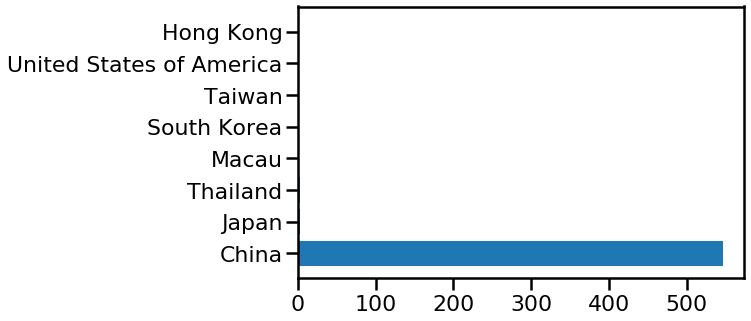

In [13]:
# plot out horizontal bar chart (the previous step visualized on horizontal bar chart)
fig, ax = plt.subplots(figsize=(8,5))
ax.barh(dff['country/region'], dff['confirmed']); #plug in your x and y, y being the horse you want to race

## Now, let's give each country a color by its continent (coloring the bars)

### 3. Get list of all countries

In [14]:
top_countries = df.groupby(['country/region'])['confirmed'].sum().sort_values(ascending=False).reset_index()['country/region'].unique()
top_countries = list(top_countries)
top_countries[0:3] #essentially a list of all countries

['United States of America', 'China', 'Italy']

In [15]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2

continents = {
    'NA': 'North America',
    'SA': 'South America', 
    'AS': 'Asia',
    'OC': 'Australia',
    'AF': 'Africa',
    'EU': 'Europe'
}

# use our 'top_countries' variable as our country list
## what our code below is doing
#it takes a country like 'China' you have right now and turns it into a a country code 'CN' then into a 
#continent code 'AS', and finally matches it with the continent dictionary to give you the full name, 'Asia'
top_continents = [continents[country_alpha2_to_continent_code(country_name_to_country_alpha2(country))]
                  for country in top_countries]

### 4. Assign Hexcode Colors to Each Country Based on Continent

#### I created a function to generate hexcode colors based on a tutorial. You can use your own hexcodes for the continents or randomly generate them. I used a combination of both. Whichever method you choose, you need to zip the continent to a color.

##### Steps: 
1. Get 6 hexcode colors, one for each continent 
2. Assign a color to each continent 
3. Assign a continent to each country.

In [16]:
# Random Hexcode Generator

# generate random hexcodes (source: https://www.codespeedy.com/create-random-hex-color-code-in-python/)
import random
random_number = random.randint(0,16777215)
hex_number = str(hex(random_number))
hex_number ='#'+ hex_number[2:]

# my function generates the amount of colors you need 
def generate_hexcode(quantity):
    colors = []
    for i in range(0,quantity+1):
        random_number = random.randint(10000000,16777215) #minimum 8 characters
        hex_number = str(hex(random_number)) # turn our random number into a hex code
        hex_number ='#'+ hex_number[2:] # create our hashtag hexcode removing first two elements
        colors.append(hex_number)
    return colors

colors = generate_hexcode(len(continents))
colors[0:6]

['#e5849a', '#d8d212', '#e0c033', '#f33cff', '#c6682b', '#d1247d']

In [17]:
# once generated, assign color to each continent
colors = dict(zip([x for x in continents.values()], colors))
colors

{'North America': '#e5849a',
 'South America': '#d8d212',
 'Asia': '#e0c033',
 'Australia': '#f33cff',
 'Africa': '#c6682b',
 'Europe': '#d1247d'}

In [18]:
# These are the colors that I want to continue using (combo of randomly generated & chosen myself)
colors = {'North America': '#FF81C0',
 'South America': '#1FA774',
 'Asia': '#41FDFE',
 'Australia': '#90E4C1',
 'Africa': '#FFD1DF',
 'Europe': '#FCF679'}

In [19]:
# assign country to its continent, creates dictionary e.g. {'China': 'Asia','Italy': 'Europe'}
top_country_continents = dict(zip(top_countries, top_continents))

#### to get each country to have its continent color,  matplotlib gets our colors looking at our top_country_continents key, finds the continent , and matches the continent to our colors dictionary to get its color. It will do this for every country/region

In [20]:
# What we want (Should be 10 hexcodes)
# 7 countries here because the first day of our dff dataset only has 7 confirmed countries)
#example broken down below
[colors[top_country_continents[x]] for x in dff['country/region']]

['#41FDFE',
 '#41FDFE',
 '#41FDFE',
 '#41FDFE',
 '#41FDFE',
 '#41FDFE',
 '#FF81C0',
 '#41FDFE']

In [21]:
# first step
top_country_continents['China']

'Asia'

In [22]:
# second step
colors['Asia']

'#41FDFE'

In [23]:
# third step altogether
colors[top_country_continents['China']]

'#41FDFE'

### 5. Show a frame of what our race will look like

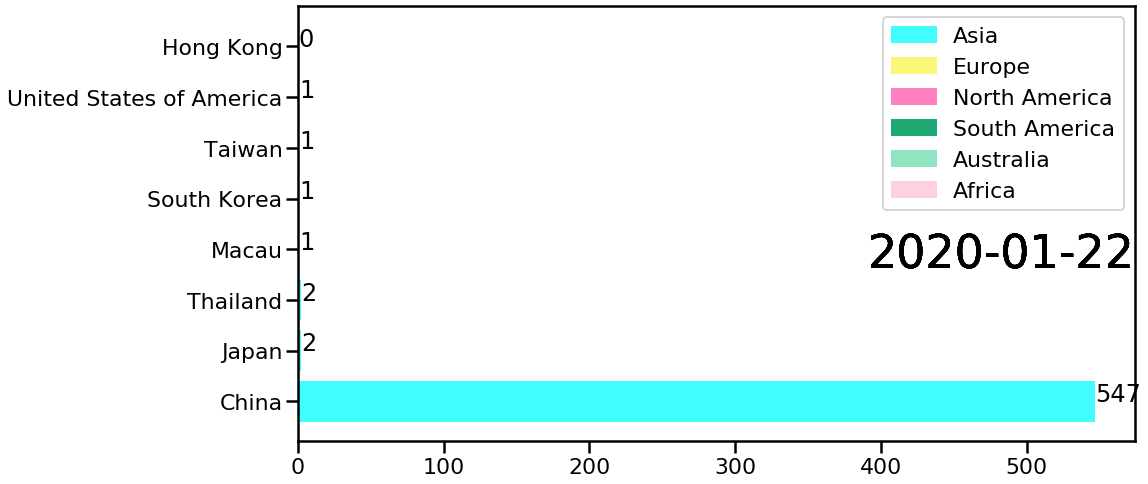

In [24]:
fig, ax = plt.subplots(figsize=(15, 8))
# pass colors values to `color=`
# iterate over the values to plot labels and values (China, Asia, 547)
ax.barh(dff['country/region'], dff['confirmed'], color=[colors[top_country_continents[x]] 
                                                        for x in dff['country/region']])


for i, (confirmed, country) in enumerate(zip(dff['confirmed'], dff['country/region'])):
    ax.text(confirmed, i,     confirmed,           ha='left')   # 38194.2: value



    # Add the large date on to plot
    ax.text(1, 0.4, beginning_date, transform=ax.transAxes, size=46, ha='right')
    countries = []
    countries.append(dff['country/region'])

    
#Legend    
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

#Create legend. If more continents are present, you can add them here
north_america = mpatches.Patch(color='#FF81C0', label='North America')
asia = mpatches.Patch(color='#41FDFE', label='Asia')
europe = mpatches.Patch(color='#FCF679', label='Europe')

##comment out countries if they don't appear in race (displaying all as example)
south_america = mpatches.Patch(color='#1FA774', label='South America')
australia = mpatches.Patch(color='#90E4C1', label='Australia')
africa = mpatches.Patch(color='#FFD1DF', label='Africa')



plt.legend(handles=[asia, europe, north_america, south_america, australia, africa]);


## 6. Calculate number of days that our data covers

In [25]:
# datetime(2019,12,31) - datetime(2019,12,31) This works!
days_since = abs((df['observationdate'].sort_values(ascending=True).head(1).item() - 
                  df['observationdate'].sort_values(ascending=False).head(1).item()).days)
days_since

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


94

In [26]:
# create a date time range that covers our data from beginning to last day of reported cases

beginning_date = df['observationdate'].sort_values(ascending=True).head(1).item()
print(beginning_date)
# create our range of dates
date_list = pd.date_range(beginning_date, periods=days_since+1).to_list() #days_since+1 to include last day
# snippet of what the timestamps look like
date_list[0].date()

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


2020-01-22


datetime.date(2020, 1, 22)

## 7. Final Function

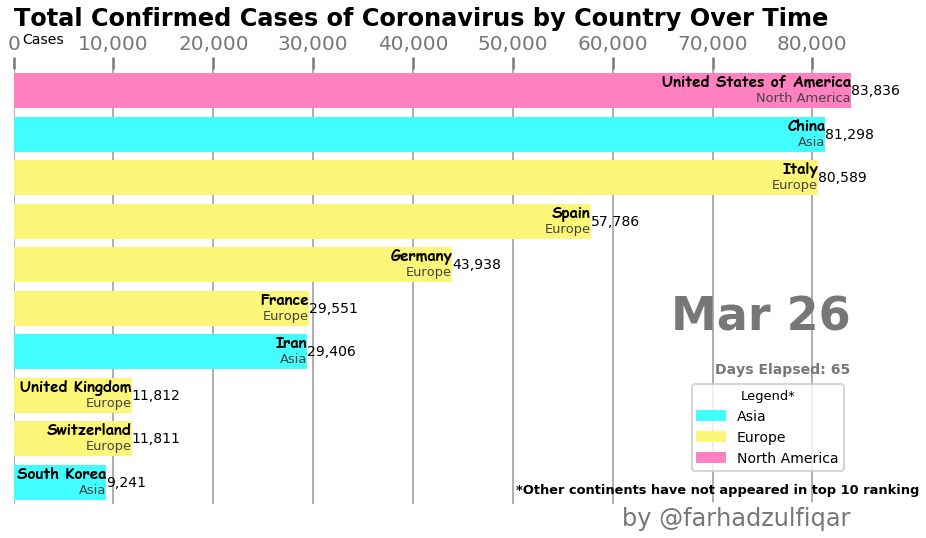

In [27]:
fig, ax = plt.subplots(figsize=(15, 8)) # initiate the figure and set size
first_day = date(2020,1,22) #this is for our days elapsed code shown in function below

def draw_barchart(date):
    dff = df[df['observationdate'].eq(date)]\
    .groupby(['country/region','observationdate'])\
    .sum().reset_index().sort_values(by='confirmed',ascending=False).head(10) # our top 10 
    
    dff = dff[::-1] #flip chart so top country is also at the top of plot
    ax.clear() # you need this to refresh the axes for the next date's statistics
    ax.barh(dff['country/region'], dff['confirmed'], \
            color=[colors[top_country_continents[x]] for x in dff['country/region']])
    

    # create loop of all our texts
    for i, (confirmed, country) in enumerate(zip(dff['confirmed'], dff['country/region'])):
        
        # Country name
        ax.text(confirmed, i,     country,           size=15, \
                weight=600, ha='right', va='bottom', fontfamily= 'fantasy') # positioned under y
        
        #Continent Name
        # "i-.25" lowers position of 'continent' under 'country'
        ax.text(confirmed, i-.25, top_country_continents[country], \
                size=13, color='#444444', ha='right', va='baseline',) #  
        
        # Number of Cases
        ax.text(confirmed, i,     f'{confirmed:,.0f}',  size=14, \
                ha='left',  va='center') 
        
    #toggle big "current date" on white space & format 
    #transaxes = sets coordination to [0,0] bottom left, [1,1] top right
    ax.text(1, 0.4, date.strftime('%b %d'), transform=ax.transAxes,  
            color='#777777', size=46, ha='right', 
            weight=800) 
    
    #toggle big "days elapsed" on white space
    days_elapsed = abs(datetime.date(date)-first_day)
    
    ax.text(1, 0.3, f'Days Elapsed: {abs(days_elapsed.days)+1}', transform=ax.transAxes, 
            color='#777777', size=14, ha='right', 
            weight=800)
            
    #sets "Cases" word in top corner
    ax.text(0.01, 1.06, 'Cases', transform=ax.transAxes, size=14, color='#000000') 
    
    # set our legend
    north_america = mpatches.Patch(color='#FF81C0', label='North America')
    asia = mpatches.Patch(color='#41FDFE', label='Asia')
    europe = mpatches.Patch(color='#FCF679', label='Europe')
    ax.legend(handles=[asia, europe, north_america],loc = 4, bbox_to_anchor=[1,0.06],fontsize=14, title='Legend*',
             title_fontsize=13)
    
    #annotate to acknowledge other continents not shown on graph
    #axes fraction = [0,0] bottom left, [1,1] top right
    ax.annotate('*Other continents have not appeared in top 10 ranking', xy=[0.6,0.025], 
                 xycoords='axes fraction', annotation_clip=True, ha='left', fontsize=13, weight=550) 
    
    
    #set number of decimal points for x-axis values
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}')) 
    ax.xaxis.set_ticks_position('top') # sets tick positions on top of plot
    ax.tick_params(axis='x', colors='#777777', labelsize=20) # adjust size of x labels (ticks)
    ax.tick_params(axis='y', colors='#000000', labelsize=15) # adjust size of y labels (ticks)
    ax.set_yticks([]) # passing an empty list removes y ticks, our y ticks will be our countries
    ax.margins(0, 0.01) #sets margin, the space alloted for the bars
    ax.grid(which='major', axis='x', linestyle='-') # sets vertical lines as place markers through race
    
    ax.set_axisbelow(True) # sets gridlines under bars, false will put lines over the bars

    
    ax.text(0, 1.10, 'Total Confirmed Cases of Coronavirus by Country Over Time',
            transform=ax.transAxes, size=24, weight=600, ha='left') #weight bolds our text

    
    ax.text(1, -.05, 'by @farhadzulfiqar', transform=ax.transAxes, ha='right',
            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))
    plt.box(False)
#     plt.savefig('lowestrace.png')            
    
    
draw_barchart(date_list[64]) #example of what the first frame would look like

From matplotlib documentation: "The use of transform=ax.transAxes throughout the code indicates that the coordinates are given relative to the axes bounding box, with 0,0 being the lower left of the axes and 1,1 the upper right."

### Run our Bar Chart Race

In [ ]:
## import matplotlib.animation as our animator
from IPython.display import HTML
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, 
                                   frames=date_list)

HTML(animator.to_jshtml())  # play in notebook inline views or use 
writer = animation.ImageMagickFileWriter()
animator.save('COVID19RaceBarChart.gif', writer=writer)

In [ ]:
#if you're on a mac - 
#first install homebrew
#then type brew install imagemagick
#create imagemagick writer object


writer = animation.ImageMagickFileWriter()
animator.save('lowestrace.gif', writer=writer)
